In [1]:
import torch
import requests
import numpy as np
import pandas as pd

from transformers import ViTImageProcessor, ViTModel
from PIL import Image, UnidentifiedImageError

2024-03-07 15:27:00.783617: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 15:27:01.341711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 15:27:01.343647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 15:27:02.583032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Dataset

In [2]:
df_data = pd.read_csv('nutrition.csv')
df_data

,id,calories,proteins,fat,carbohydrate,name,image
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...
2,3,0.0,0.0,0.2,0.0,Agar-agar,https://res.cloudinary.com/dk0z4ums3/image/upl...
3,4,45.0,1.1,0.4,10.8,Akar tonjong segar,https://images.tokopedia.net/img/cache/200-squ...
4,5,37.0,4.4,0.5,3.8,Aletoge segar,https://nilaigizi.com/assets/images/produk/pro...
...,...,...,...,...,...,...,...
1341,1342,42.0,1.2,0.6,9.3,Wortel Segar,https://www.astronauts.id/blog/wp-content/uplo...
1342,1343,37.0,1.0,0.6,8.3,Wortel kukus,https://www.wikihow.com/images_en/thumb/b/bf/S...
1343,1344,28.0,0.7,0.5,6.3,Wortel rebus,https://asset-a.grid.id/crop/0x222:594x690/700...
1344,1345,254.0,3.0,1.1,58.1,Yangko,https://serikatnews.com/wp-content/uploads/202...


In [3]:
df_data.isna().sum()

id              0
calories        0
proteins        0
fat             0
carbohydrate    0
name            0
image           0
dtype: int64

# Generate Vector Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Inisialisasi ViTImageProcessor dan ViTModel
processor = ViTImageProcessor.from_pretrained('google/vit-large-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-large-patch16-224-in21k').to(device)

Using device: cpu


<class 'PIL.JpegImagePlugin.JpegImageFile'> <class 'list'>
[-0.25888484716415405, 0.08714423328638077, 0.6493053436279297, 0.2013118416070938, 0.03558092191815376, -0.2384720891714096, 0.008141694590449333, 0.08183329552412033, -0.38792672753334045, -0.1510586440563202]


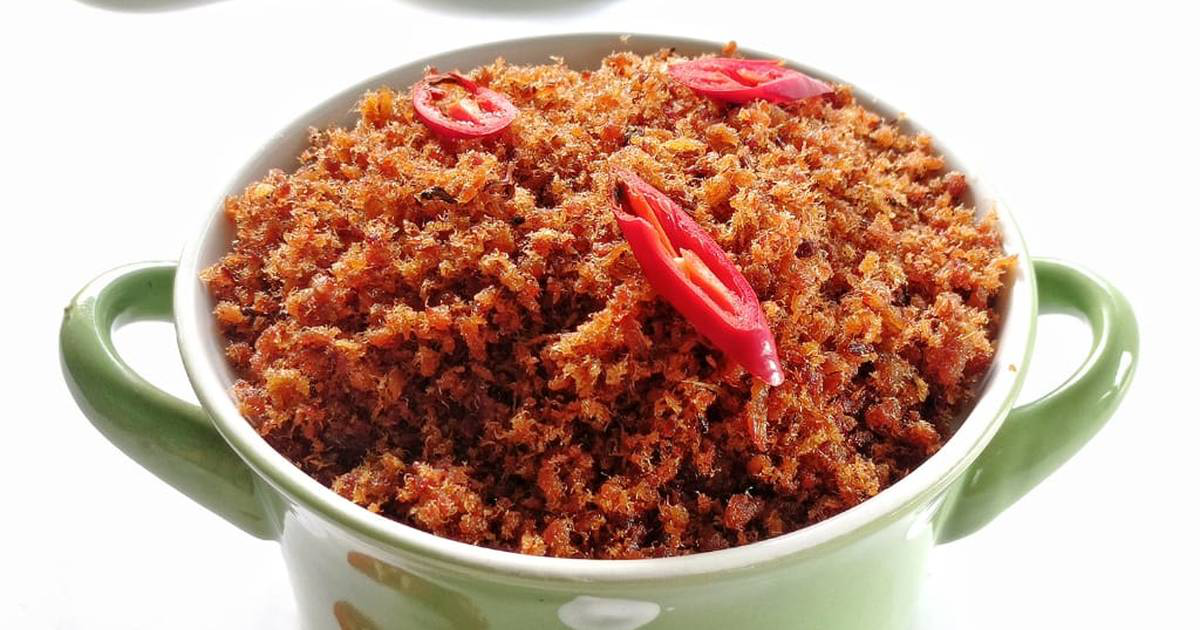

In [6]:
def load_image_url(image_url):
    image = Image.open(requests.get(image_url, stream=True).raw)
    return image

def get_vector_image(image):
    # Membuat image embedding dan vector
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    vector = list(outputs.last_hidden_state[:, 0][0].detach().numpy().tolist())
    return vector

image_url = 'https://images.tokopedia.net/img/cache/200-square/product-1/2018/8/11/3052608/3052608_12e6762a-1a95-450b-8a7c-347a26dc3201_450_450.jpg'
image_url = 'https://img-global.cpcdn.com/recipes/cbf330fbd1ba6316/1200x630cq70/photo.jpg'
image = load_image_url(image_url)
vector = get_vector_image(image)
print(type(image), type(vector))
print(vector[:10])
image

In [7]:
# Membuat kolom baru untuk menyimpan vector
df_data['image_vector'] = None

n = 20
n_rows = df_data.shape[0]
for index, row in df_data.iterrows():
    print(f'{index:04d}/{n_rows:04d}. ')

    if index > n:
        break

    # Mengambil link foto dari kolom CSV
    image_url = row['image']
    try:
        # Mengambil gambar dari link
        image = load_image_url(image_url)
        vector = get_vector_image(image)

        # Menyimpan vector ke dalam DataFrame
        df_data.at[index, 'image_vector'] = vector

    except UnidentifiedImageError:
        print(f"Error: Cannot identify image file for row {index}")

    except Exception as e:
        print(f"Error: {e} for row {index}")

df_data.head(n)

0000/1346. 
0001/1346. 
0002/1346. 
0003/1346. 
0004/1346. 
0005/1346. 
Error: Cannot identify image file for row 5
0006/1346. 
0007/1346. 
0008/1346. 
0009/1346. 
0010/1346. 
Error: Cannot identify image file for row 10
0011/1346. 
0012/1346. 
0013/1346. 
0014/1346. 
0015/1346. 
0016/1346. 
0017/1346. 
0018/1346. 
0019/1346. 
0020/1346. 
0021/1346. 


,id,calories,proteins,fat,carbohydrate,name,image,image_vector
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...,"[0.048166681081056595, 0.8722032308578491, 0.8..."
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...,"[-0.25888484716415405, 0.08714423328638077, 0...."
2,3,0.0,0.0,0.2,0.0,Agar-agar,https://res.cloudinary.com/dk0z4ums3/image/upl...,"[0.3128243386745453, -0.6301677823066711, -0.2..."
3,4,45.0,1.1,0.4,10.8,Akar tonjong segar,https://images.tokopedia.net/img/cache/200-squ...,"[1.0423359870910645, -0.38742366433143616, 0.4..."
4,5,37.0,4.4,0.5,3.8,Aletoge segar,https://nilaigizi.com/assets/images/produk/pro...,"[-0.19335131347179413, 0.10294303297996521, 0...."
5,6,85.0,0.9,6.5,7.7,Alpukat segar,https://katakabar.com/assets/images/upload/new...,None
6,7,96.0,3.7,0.6,19.1,Ampas kacang hijau,https://images.tokopedia.net/img/cache/215-squ...,"[-0.7686520218849182, 0.3278096914291382, -0.1..."
7,8,414.0,26.6,18.3,41.3,Ampas Tahu,https://palpres.disway.id/upload/9e9c1ba592cac...,"[-0.11918795108795166, -0.36174365878105164, 0..."
8,9,75.0,4.1,2.1,10.7,Ampas tahu kukus,https://cdns.diadona.id/diadona.id/resized/640...,"[-0.5469316244125366, 0.06194315105676651, 0.8..."
9,10,67.0,5.0,2.1,8.1,Ampas tahu mentah,https://cdn-image.hipwee.com/wp-content/upload...,"[-0.6136888265609741, -0.13959775865077972, 0...."


# Vector Search

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
df_vector_db = df_data.dropna()
df_vector_db

,id,calories,proteins,fat,carbohydrate,name,image,image_vector
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...,"[0.048166681081056595, 0.8722032308578491, 0.8..."
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...,"[-0.25888484716415405, 0.08714423328638077, 0...."
2,3,0.0,0.0,0.2,0.0,Agar-agar,https://res.cloudinary.com/dk0z4ums3/image/upl...,"[0.3128243386745453, -0.6301677823066711, -0.2..."
3,4,45.0,1.1,0.4,10.8,Akar tonjong segar,https://images.tokopedia.net/img/cache/200-squ...,"[1.0423359870910645, -0.38742366433143616, 0.4..."
4,5,37.0,4.4,0.5,3.8,Aletoge segar,https://nilaigizi.com/assets/images/produk/pro...,"[-0.19335131347179413, 0.10294303297996521, 0...."
6,7,96.0,3.7,0.6,19.1,Ampas kacang hijau,https://images.tokopedia.net/img/cache/215-squ...,"[-0.7686520218849182, 0.3278096914291382, -0.1..."
7,8,414.0,26.6,18.3,41.3,Ampas Tahu,https://palpres.disway.id/upload/9e9c1ba592cac...,"[-0.11918795108795166, -0.36174365878105164, 0..."
8,9,75.0,4.1,2.1,10.7,Ampas tahu kukus,https://cdns.diadona.id/diadona.id/resized/640...,"[-0.5469316244125366, 0.06194315105676651, 0.8..."
9,10,67.0,5.0,2.1,8.1,Ampas tahu mentah,https://cdn-image.hipwee.com/wp-content/upload...,"[-0.6136888265609741, -0.13959775865077972, 0...."
11,12,174.0,19.6,10.0,0.0,Anak sapi daging kurus segar,https://asset.kompas.com/crops/BzqLdMzV0nYuuT_...,"[-0.846342921257019, -0.27974554896354675, -0...."


In [61]:
def search_image(image_input, df_vector_db, top=5):
    vector_input = get_vector_image(image_input)
    df_vector_db['similarity'] = df_vector_db.apply(
        lambda row: cosine_similarity(
            np.array(row['image_vector']).reshape(1, -1),
            np.array(vector_input).reshape(1, -1),
        )[0][0], 
        axis=1
    )
    df_vector_db = df_vector_db.sort_values(by='similarity', ascending=False).head(top).copy()

    # Show
    fig, ax = plt.subplots(1, 4, figsize=(4 * 10, 10))
    fig.suptitle(f'Similarity')
    ax[0].imshow(image_input)
    ax[0].set_title('Input')
    for i in range(3):
        url, name, score = df_vector_db.iloc[i][['image', 'name', 'similarity']]
        image_output = load_image_url(url)
        
        ax[1 + i].imshow(image_output)
        ax[1 + i].set_title(f'{name}: {score:0.2f}')

    fig.show()

    return df_vector_db

/tmp/ipykernel_2890404/1089788918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vector_db['similarity'] = df_vector_db.apply(


,id,calories,proteins,fat,carbohydrate,name,image,image_vector,similarity
1,2,513.0,23.7,37.0,21.3,Abon haruwan,https://img-global.cpcdn.com/recipes/cbf330fbd...,"[-0.25888484716415405, 0.08714423328638077, 0....",0.629688
0,1,280.0,9.2,28.4,0.0,Abon,https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...,"[0.048166681081056595, 0.8722032308578491, 0.8...",0.536876
7,8,414.0,26.6,18.3,41.3,Ampas Tahu,https://palpres.disway.id/upload/9e9c1ba592cac...,"[-0.11918795108795166, -0.36174365878105164, 0...",0.235402
11,12,174.0,19.6,10.0,0.0,Anak sapi daging kurus segar,https://asset.kompas.com/crops/BzqLdMzV0nYuuT_...,"[-0.846342921257019, -0.27974554896354675, -0....",0.127672
12,13,190.0,19.1,12.0,0.0,Anak sapi daging sedang segar,https://koran-jakarta.com/images/article/tips-...,"[-0.827293872833252, -0.33801233768463135, -0....",0.118478


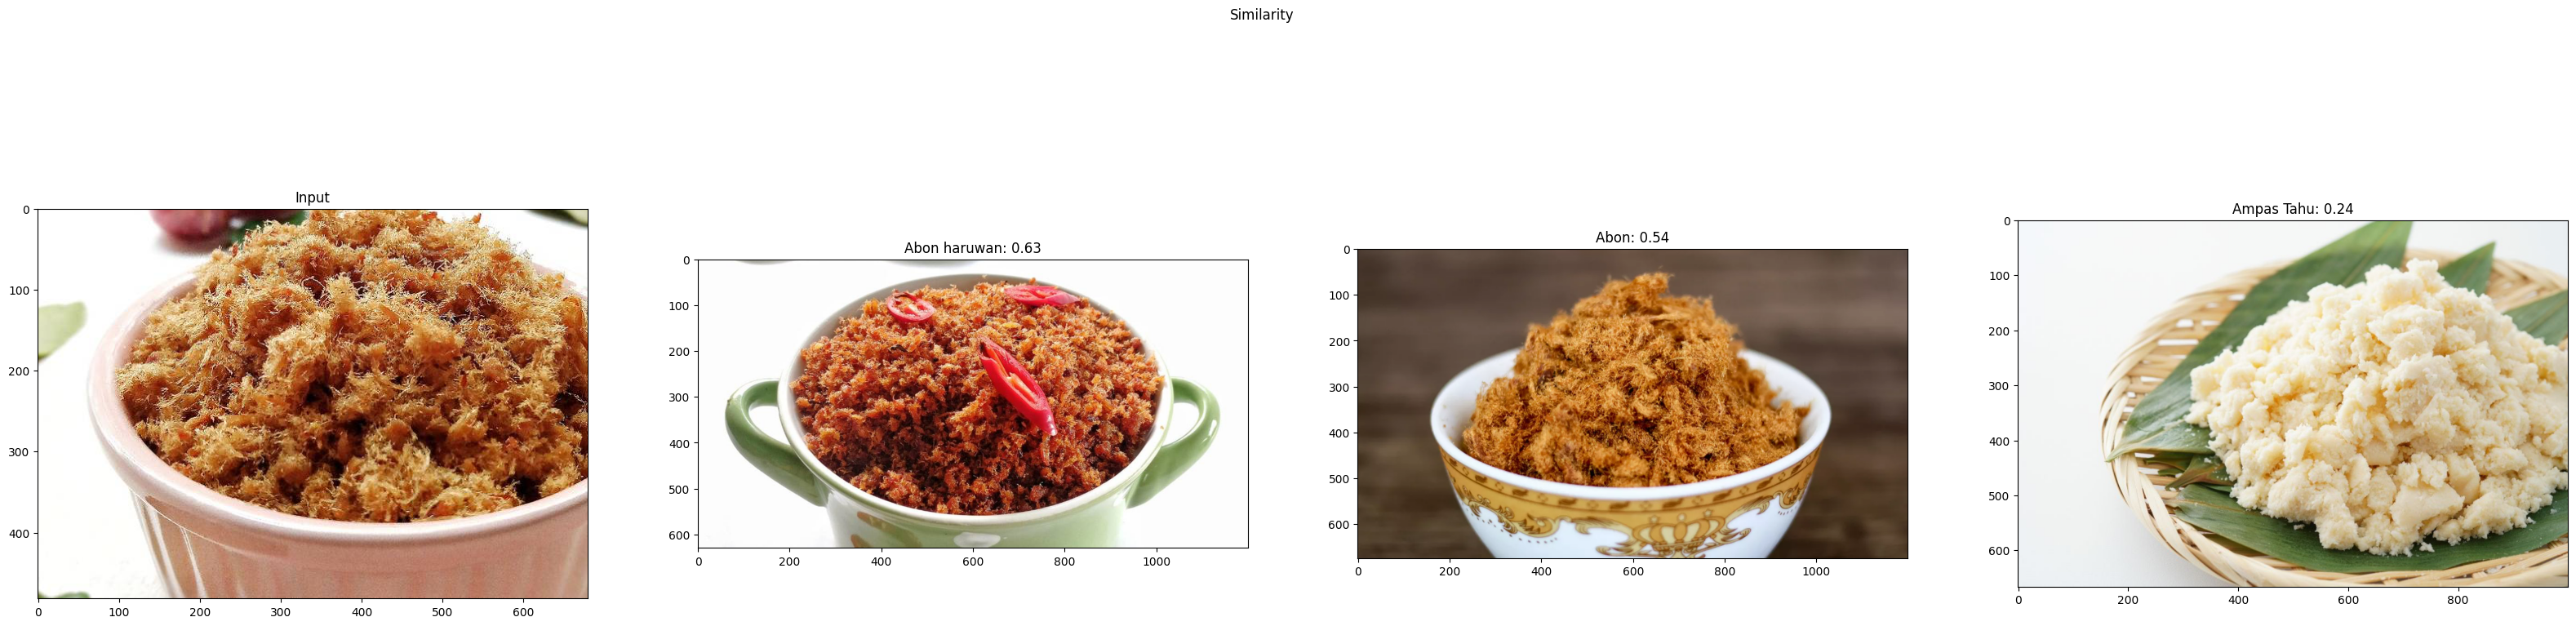

In [62]:
# Abon
url_input = 'https://static.promediateknologi.id/crop/0x0:0x0/750x500/webp/photo/2023/07/04/abon-sapi-1-149434320.jpg'
url_input = 'https://asset.kompas.com/crops/yhVrz5DWFdNMQBZncjRrAWvZZek=/47x12:998x645/750x500/data/photo/2020/07/20/5f1566021caf1.jpg'
url_input = 'https://img-global.cpcdn.com/recipes/9627749bff4ec6ec/680x482cq70/abon-sapi-homemade-foto-resep-utama.jpg'

image_input = load_image_url(url_input)

df_rcmd = search_image(image_input, df_vector_db)
df_rcmd

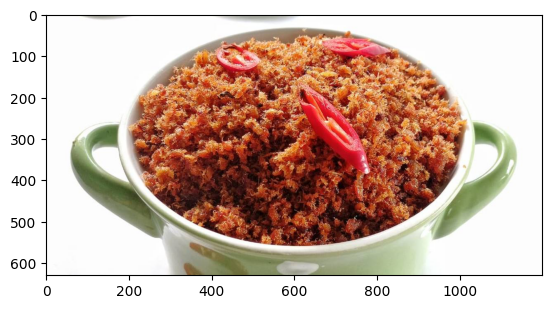

In [23]:
url_output = df_rcmd['image'].tolist()[0]
image_output = load_image_url(url_output)
plt.imshow(image_output)

In [30]:
axarr[0]

<Axes: >